# Implementation of Partner Selection Procedures

## Abstract

In this paper[1], Stubinger, Mangold and Krauss  developed  a  multivariate  statistical  arbitrage  strategy  based  on  vine  copulas  -  a  highly flexible instrument for linear and nonlinear multivariate dependence modeling. Pairs trading is a relative-value arbitrage strategy, where an investor seeks to profit from mean-reversion properties of the price spread between two co-moving securities. Existing literature focused on using  bivariate  copulas  to  model the dependence structure between two stock return time series, and to identify mispricings that can potentially be exploited in a pairs trading application. 

This paper proposes a multivariate copula-based statistical arbitrage framework, where specifically, for each stock in the S&P 500 data base, the three most suitable partners are selected by leveraging different selection criteria. Then, the multivariate copula models are benchmarked to capture the dependence structure of the selected quadruples. Later on, the paper focusses on the generation of trading signals and backtesting.


## Introduction

This notebook will focus on the various Partner Selection procedures and their implementations, as described in the paper. For every stock in the S&P 500, a partner triple is identified based on adequate measures of association. The following four partner selection approaches are implemented :
- Traditional Approach - baseline approach where the high dimensional relation between the four stocks is approximated by their pairwise bivariate correlations via Spearman’s $\rho$;
- Extended Approach - calculating the multivariate version of Spearman’s $\rho$ based on Schmid and Schmidt (2007)[2];
- Geometric Approach - involves calculating the sum of euclidean distances from the 4-dimensional hyper-diagonal;
- Extremal Approach - involves calculating a non-parametric $\chi^2$ test statistic based on Mangold (2015)[3] to measure the degree of deviation from independence.

Firstly, all measures of association are calculated using the ranks of the daily discrete returns of our samples. Ranked transformation provides robustness against outliers. Secondly, only the top 50 most highly correlated stocks are taken into consideration for each target stock, to reduce the computational burden.

---

# Preprocessing

In [20]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [42]:
from partner_selection import PartnerSelection
from ps_utils import get_sector_data
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

# Loading the data set

Dataset contains daily pricing data for all stocks in S&P 500. Data from the year 2016 is taken into consideration for this notebook.

When a PartnerSelection object is created, daily returns of the stocks and their corresponding ranked returns are calculated and stored as attributes. 

In [22]:
df = pd.read_csv('./data/data.csv', parse_dates=True, index_col='Date').dropna()
df = df['2016'] #Taking 12 month data as mentioned in the paper
ps = PartnerSelection(df)

constituents = pd.read_csv('./data/constituents-detailed.csv', index_col='Symbol')

In [23]:
print(ps.top_50_correlations)

        0     1     2    3     4     5     6      7     8     9   ...    40  \
A      TMO   PKI   WAT  MTD  SPGI   ABT   AMP   ADSK  AMGN   BLK  ...   BEN   
AAL    UAL   DAL   LUV  ALK   MCO     C   DFS     MS   AMP   TDG  ...  NTRS   
AAP    AZO  ORLY    TT  GPC  ALLE   RHI  ODFL    LOW  ULTA   TJX  ...  DLTR   
AAPL  AVGO  SWKS   TXN  ADI  LRCX  INTC  MXIM  GOOGL  GOOG  QRVO  ...   VAR   
ABBV  AMGN   ABT  REGN  MYL   WAT  VRTX   ZTS   ILMN  BIIB  INCY  ...  ISRG   
...    ...   ...   ...  ...   ...   ...   ...    ...   ...   ...  ...   ...   
YUM   TROW     V  SBAC  ITW   AJG   MCO   MHK    ADP  ORCL    GE  ...   ALB   
ZBH    BSX   BDX   VAR  MDT   ABT   TMO   MTD   HOLX   PKI   WAT  ...   TFX   
ZBRA  KEYS   TEL  NTAP  IEX   APH   FLT  AKAM    TDY   BEN  SCHW  ...  CSCO   
ZION    RF   CMA  FITB  KEY   TFC   PNC  HBAN    MTB  NTRS   JPM  ...   BEN   
ZTS    VAR   CAH   ABT  MTD   BIO  INTU    EW    MYL   PKI  ABBV  ...   ADP   

        41    42    43    44    45    46    47    4

# Step 1 : Traditional Approach

- Calculate the sum of all pairwise correlations for all possible quadruples, consisting of a fixed target stock.
- Quadruple with the largest sum of pairwise correlations is considered as the final quadruple and saved to the output matrix.

['A', 'TMO', 'PKI', 'WAT']
['AAL', 'UAL', 'DAL', 'LUV']
['AAP', 'TT', 'PH', 'ETN']
['AAPL', 'TXN', 'ADI', 'INTC']
['ABBV', 'AMGN', 'REGN', 'BIIB']
['ABC', 'JPM', 'TFC', 'PNC']
['ABMD', 'WAT', 'PKI', 'TMO']
['ABT', 'TMO', 'A', 'WAT']
['ACN', 'ADP', 'JKHY', 'FISV']
['ADBE', 'GOOG', 'MSFT', 'GOOGL']
['ADI', 'TXN', 'MCHP', 'INTC']
['ADM', 'BEN', 'TROW', 'IVZ']
['ADP', 'PAYX', 'FISV', 'JKHY']
['ADSK', 'C', 'BK', 'SCHW']
['AEE', 'XEL', 'WEC', 'CMS']
['AEP', 'XEL', 'DUK', 'WEC']
['AES', 'AEP', 'CMS', 'XEL']
['AFL', 'UNM', 'PRU', 'LNC']
['AIG', 'PRU', 'MET', 'LNC']
['AIV', 'UDR', 'AVB', 'ESS']
[['A', 'TMO', 'PKI', 'WAT'], ['AAL', 'UAL', 'DAL', 'LUV'], ['AAP', 'TT', 'PH', 'ETN'], ['AAPL', 'TXN', 'ADI', 'INTC'], ['ABBV', 'AMGN', 'REGN', 'BIIB'], ['ABC', 'JPM', 'TFC', 'PNC'], ['ABMD', 'WAT', 'PKI', 'TMO'], ['ABT', 'TMO', 'A', 'WAT'], ['ACN', 'ADP', 'JKHY', 'FISV'], ['ADBE', 'GOOG', 'MSFT', 'GOOGL'], ['ADI', 'TXN', 'MCHP', 'INTC'], ['ADM', 'BEN', 'TROW', 'IVZ'], ['ADP', 'PAYX', 'FISV', 'JKHY'], ['

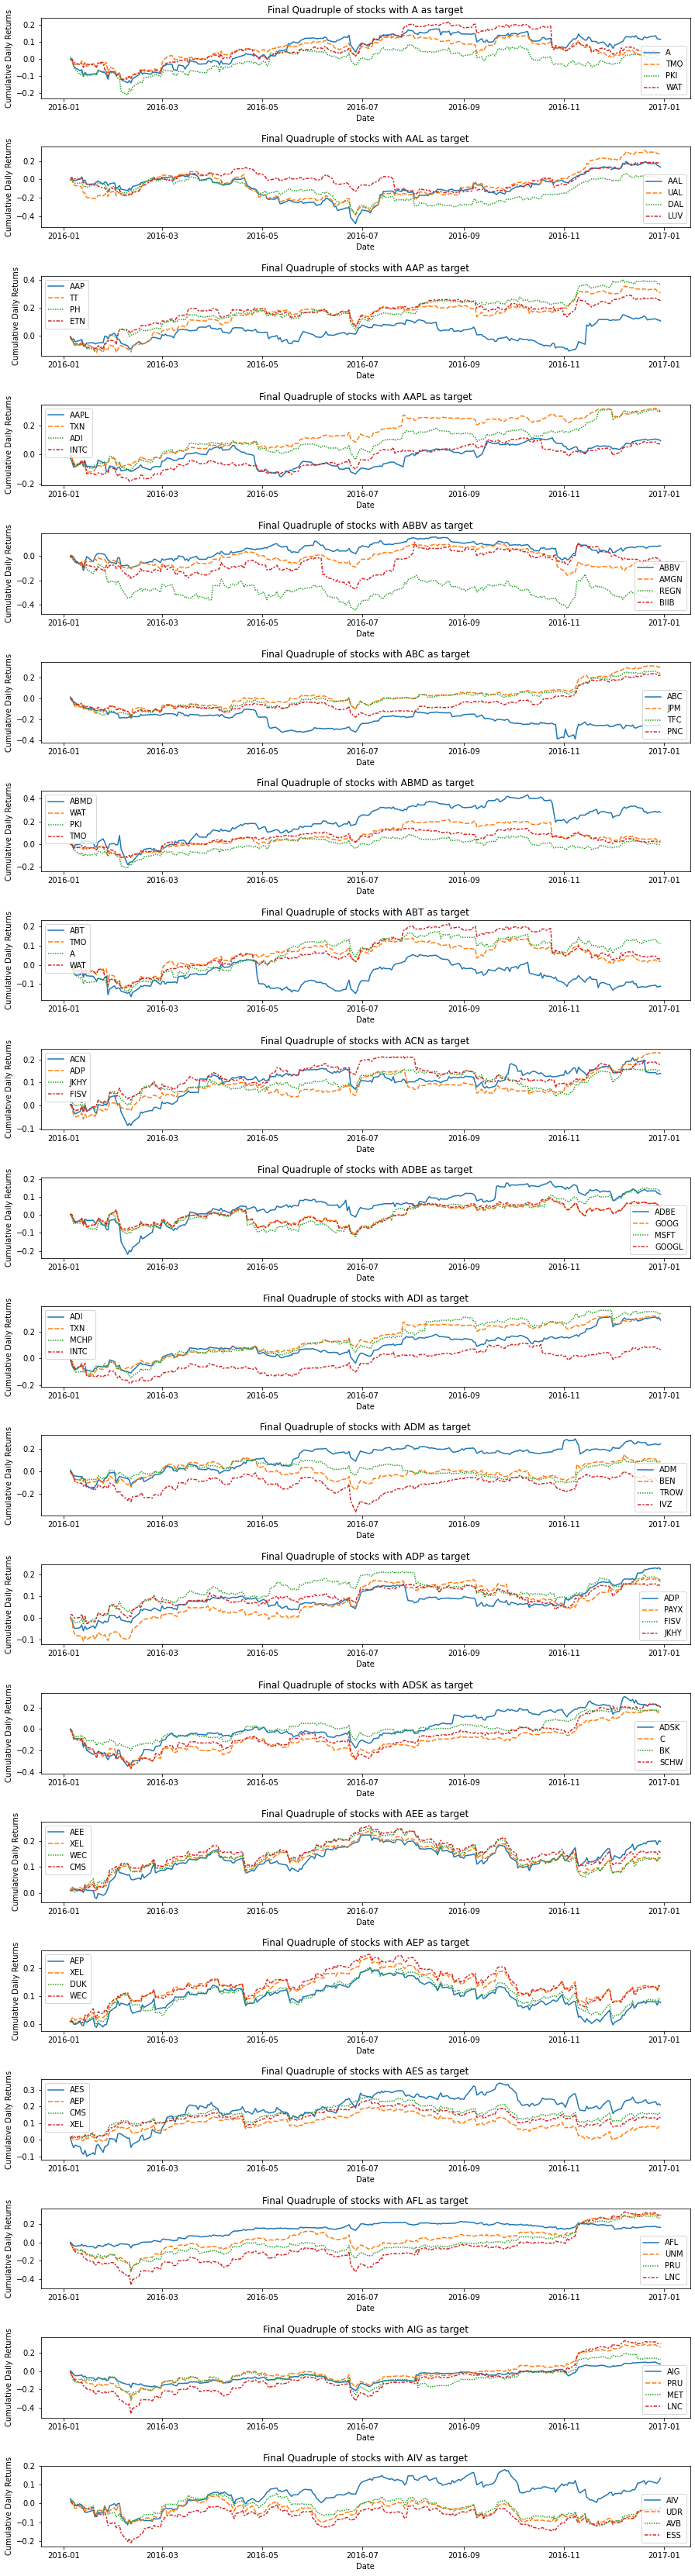

In [35]:
Q = ps.traditional_multiprocess(20)
print(Q)
ps.plot_selected_pairs(Q)

In [36]:
for quadruple in Q:
    display(get_sector_data(quadruple,constituents))

,Security,GICS Sector,GICS Sub-Industry
Symbol,,,
A,Agilent Technologies,Health Care,Health Care Equipment
TMO,Thermo Fisher Scientific,Health Care,Life Sciences Tools & Services
PKI,PerkinElmer,Health Care,Health Care Equipment
WAT,Waters Corporation,Health Care,Health Care Distributors


,Security,GICS Sector,GICS Sub-Industry
Symbol,,,
AAL,American Airlines Group,Industrials,Airlines
UAL,United Airlines Holdings,Industrials,Airlines
DAL,Delta Air Lines Inc.,Industrials,Airlines
LUV,Southwest Airlines,Industrials,Airlines


,Security,GICS Sector,GICS Sub-Industry
Symbol,,,
AAP,Advance Auto Parts,Consumer Discretionary,Automotive Retail
TT,Trane Technologies plc,Industrials,Building Products
PH,Parker-Hannifin,Industrials,Industrial Machinery
ETN,Eaton Corporation,Industrials,Electrical Components & Equipment


,Security,GICS Sector,GICS Sub-Industry
Symbol,,,
AAPL,Apple Inc.,Information Technology,"Technology Hardware, Storage & Peripherals"
TXN,Texas Instruments,Information Technology,Semiconductors
ADI,"Analog Devices, Inc.",Information Technology,Semiconductors
INTC,Intel Corp.,Information Technology,Semiconductors


,Security,GICS Sector,GICS Sub-Industry
Symbol,,,
ABBV,AbbVie Inc.,Health Care,Pharmaceuticals
AMGN,Amgen Inc.,Health Care,Biotechnology
REGN,Regeneron Pharmaceuticals,Health Care,Biotechnology
BIIB,Biogen Inc.,Health Care,Biotechnology


,Security,GICS Sector,GICS Sub-Industry
Symbol,,,
ABC,AmerisourceBergen Corp,Health Care,Health Care Distributors
JPM,JPMorgan Chase & Co.,Financials,Diversified Banks
TFC,Truist Financial,Financials,Regional Banks
PNC,PNC Financial Services,Financials,Regional Banks


,Security,GICS Sector,GICS Sub-Industry
Symbol,,,
ABMD,Abiomed,Health Care,Health Care Equipment
WAT,Waters Corporation,Health Care,Health Care Distributors
PKI,PerkinElmer,Health Care,Health Care Equipment
TMO,Thermo Fisher Scientific,Health Care,Life Sciences Tools & Services


,Security,GICS Sector,GICS Sub-Industry
Symbol,,,
ABT,Abbott Laboratories,Health Care,Health Care Equipment
TMO,Thermo Fisher Scientific,Health Care,Life Sciences Tools & Services
A,Agilent Technologies,Health Care,Health Care Equipment
WAT,Waters Corporation,Health Care,Health Care Distributors


,Security,GICS Sector,GICS Sub-Industry
Symbol,,,
ACN,Accenture plc,Information Technology,IT Consulting & Other Services
ADP,Automatic Data Processing,Information Technology,Data Processing & Outsourced Services
JKHY,Jack Henry & Associates,Information Technology,Data Processing & Outsourced Services
FISV,Fiserv Inc,Information Technology,Data Processing & Outsourced Services


,Security,GICS Sector,GICS Sub-Industry
Symbol,,,
ADBE,Adobe Inc.,Information Technology,Application Software
GOOG,Alphabet Inc. (Class C),Communication Services,Interactive Media & Services
MSFT,Microsoft Corp.,Information Technology,Systems Software
GOOGL,Alphabet Inc. (Class A),Communication Services,Interactive Media & Services


,Security,GICS Sector,GICS Sub-Industry
Symbol,,,
ADI,"Analog Devices, Inc.",Information Technology,Semiconductors
TXN,Texas Instruments,Information Technology,Semiconductors
MCHP,Microchip Technology,Information Technology,Semiconductors
INTC,Intel Corp.,Information Technology,Semiconductors


,Security,GICS Sector,GICS Sub-Industry
Symbol,,,
ADM,Archer-Daniels-Midland Co,Consumer Staples,Agricultural Products
BEN,Franklin Resources,Financials,Asset Management & Custody Banks
TROW,T. Rowe Price Group,Financials,Asset Management & Custody Banks
IVZ,Invesco Ltd.,Financials,Asset Management & Custody Banks


,Security,GICS Sector,GICS Sub-Industry
Symbol,,,
ADP,Automatic Data Processing,Information Technology,Data Processing & Outsourced Services
PAYX,Paychex Inc.,Information Technology,Data Processing & Outsourced Services
FISV,Fiserv Inc,Information Technology,Data Processing & Outsourced Services
JKHY,Jack Henry & Associates,Information Technology,Data Processing & Outsourced Services


,Security,GICS Sector,GICS Sub-Industry
Symbol,,,
ADSK,Autodesk Inc.,Information Technology,Application Software
C,Citigroup Inc.,Financials,Diversified Banks
BK,The Bank of New York Mellon,Financials,Asset Management & Custody Banks
SCHW,Charles Schwab Corporation,Financials,Investment Banking & Brokerage


,Security,GICS Sector,GICS Sub-Industry
Symbol,,,
AEE,Ameren Corp,Utilities,Multi-Utilities
XEL,Xcel Energy Inc,Utilities,Multi-Utilities
WEC,WEC Energy Group,Utilities,Electric Utilities
CMS,CMS Energy,Utilities,Multi-Utilities


,Security,GICS Sector,GICS Sub-Industry
Symbol,,,
AEP,American Electric Power,Utilities,Electric Utilities
XEL,Xcel Energy Inc,Utilities,Multi-Utilities
DUK,Duke Energy,Utilities,Electric Utilities
WEC,WEC Energy Group,Utilities,Electric Utilities


,Security,GICS Sector,GICS Sub-Industry
Symbol,,,
AES,AES Corp,Utilities,Independent Power Producers & Energy Traders
AEP,American Electric Power,Utilities,Electric Utilities
CMS,CMS Energy,Utilities,Multi-Utilities
XEL,Xcel Energy Inc,Utilities,Multi-Utilities


,Security,GICS Sector,GICS Sub-Industry
Symbol,,,
AFL,Aflac,Financials,Life & Health Insurance
UNM,Unum Group,Financials,Life & Health Insurance
PRU,Prudential Financial,Financials,Life & Health Insurance
LNC,Lincoln National,Financials,Multi-line Insurance


,Security,GICS Sector,GICS Sub-Industry
Symbol,,,
AIG,American International Group,Financials,Property & Casualty Insurance
PRU,Prudential Financial,Financials,Life & Health Insurance
MET,MetLife Inc.,Financials,Life & Health Insurance
LNC,Lincoln National,Financials,Multi-line Insurance


None

['A', 'TMO', 'PKI', 'WAT']


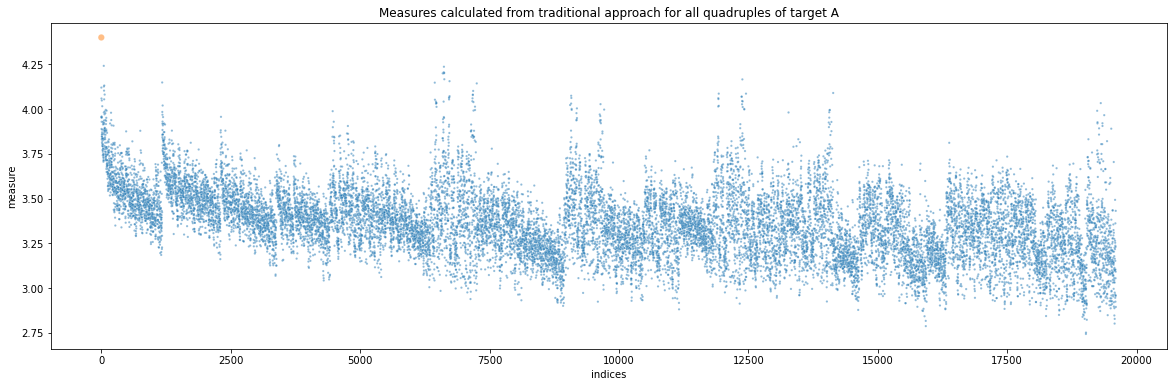

In [37]:
#Plotting measures of all quadruples for a given target
ps.plot_all_target_measures(target='A', procedure='traditional')

# Step 2 : Extended Approach

- Calculate the multivariate version of Spearman’s $\rho$ for all possible quadruples, consisting of a fixed target stock.
- Quadruple with the largest value is considered as the final quadruple and saved to the output matrix.

In [7]:
Q = ps.extended_multiprocess(20)
print(Q)
ps.plot_selected_pairs(Q)

AttributeError: 'NoneType' object has no attribute 'iloc'

In [8]:
for quadruple in Q:
    display(get_sector_data(quadruple,constituents))

NameError: name 'Q' is not defined

In [9]:
#Plotting measures of all quadruples for a given target
ps.plot_all_target_measures(target='A', procedure='extended')

KeyboardInterrupt: 

# Step 3 : Geometric Approach

- Calculate the four dimensional diagonal measure for all possible quadruples, consisting of a fixed target stock.
- Quadruple with the smallest diagonal measure is considered as the final quadruple and saved to the output matrix.

In [ ]:
Q = ps.geometric_multiprocess(20)
print(Q)
ps.plot_selected_pairs(Q)

In [ ]:
for quadruple in Q:
    display(get_sector_data(quadruple,constituents))

In [ ]:
#Plotting measures of all quadruples for a given target
ps.plot_all_target_measures(target='A', procedure='geometric')

# Step 4 : Extremal Approach

- Calculate the $\chi^2$ test statistic for all possible quadruples, consisting of a fixed target stock.
- Quadruple with the largest test statistic is considered as the final quadruple and saved to the output matrix.

In [ ]:
Q = ps.extremal(20)
print(Q)
ps.plot_selected_pairs(Q)

In [ ]:
for quadruple in Q:
    display(get_sector_data(quadruple,constituents))

In [ ]:
#Plotting measures of all quadruples for a given target
ps.plot_all_target_measures(target='A', procedure='extremal')

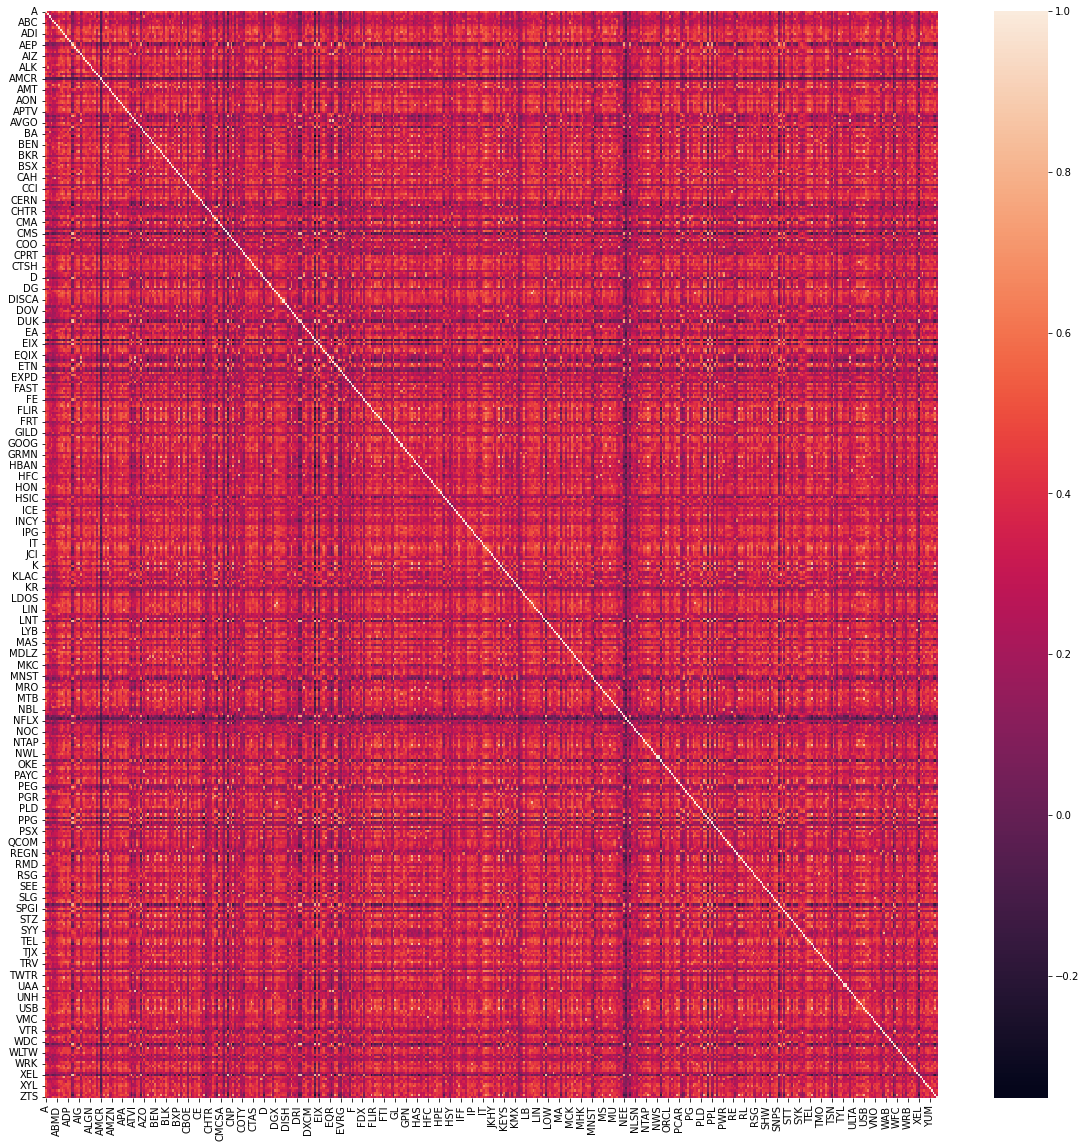

In [38]:
#Plotting the correlation matrix heatmap of all stocks on S&P 500
ps.plot_correlation()

# Conclusion

This notebook describes the proposed Partner Selection Framework, also showcasing example usage of the implemented framework.

The first three procedures seem to generate the same final set of quadruples for every target stock in the universe. Another important takeaway is the Industry/Sub-Sector of the stocks in most of the final quadruples are highly correlated, even though clustering methods were not used in this framework.

Some Interesting Observations:
- ABC(AmerisourceBergen Corp) which is a Health Care Distibutor seems to have highly correlated partners in Financial Services. This observation holds true for all four approaches.
- For ABT(Abbott Laboratories), a Health Care Equipment Manufacturer, Extremal Approach returned three partners which are in Financial Services. This behaviour is against the results obtained from the other three approaches.
- According to all four approaches, ADM(Archer-Daniels-Midland Co) an Agricultural Products business, seems to have highly correlated partners in Asset Management.  


# References
[1]. Stübinger, Johannes; Mangold, Benedikt; Krauss, Christopher. Statistical Arbitrage with Vine Copulas. Available at: https://www.econstor.eu/bitstream/10419/147450/1/870932616.pdf

[2]. Schmid, F., Schmidt, R., 2007. Multivariate extensions of Spearman’s rho and related statis-tics. Statistics & Probability Letters 77 (4), 407–416.

[3]. Mangold, B., 2015. A multivariate linear rank test of independence based on a multipara-metric copula with cubic sections. IWQW Discussion Paper Series, University of Erlangen-N ̈urnberg. Available at: https://www.statistik.rw.fau.de/files/2016/03/IWQW-10-2015.pdf


In [61]:
import pyvinecopulib as pv
import numpy as np

In [80]:
returns = ps.get_selected_pair_returns(Q)[1].to_numpy()

In [133]:
from copulas.multivariate import VineCopula

u = pd.DataFrame(pv.to_pseudo_obs(returns), columns=['s1', 's2', 's3', 's4'])
center = VineCopula('center')
center.fit(u)

In [137]:
center_samples = center.sample(1000)

In [157]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

def scatter_4d(u):
    fig = plt.figure(figsize=(10, 10))
    ax1 = fig.add_subplot(111, projection='3d')
    img = ax1.scatter(u['s1'], u['s2'], u['s3'], c=u['s4'], cmap=plt.hot())

    fig.colorbar(img)
    plt.show()

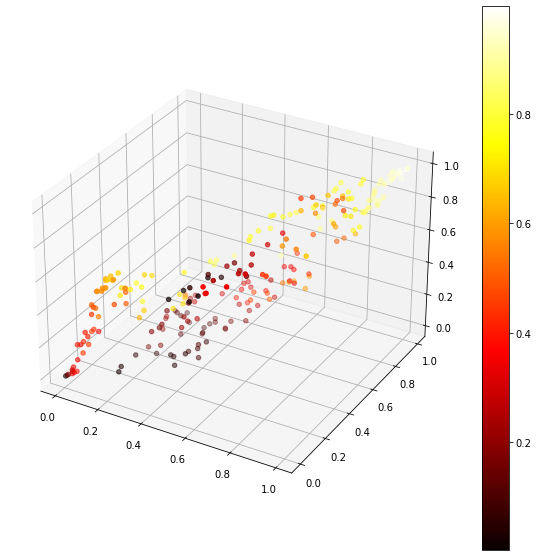

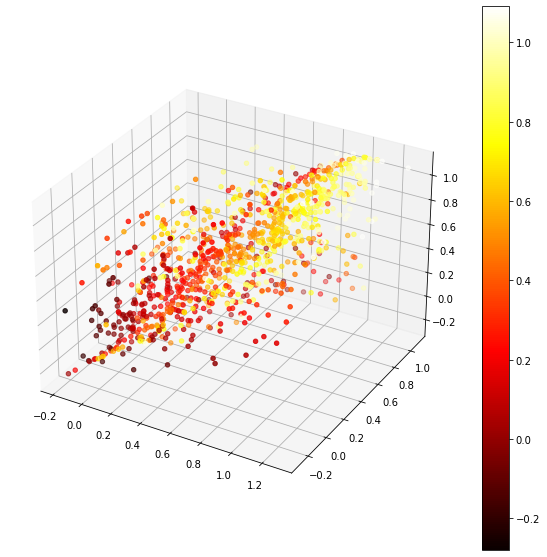

In [158]:
arrays = {'real': u, 'sampled': center_samples}
position_base = f'1{len(arrays)}'
for index, (title, array) in enumerate(arrays.items()):
    position = int(position_base + str(index + 1))
    scatter_4d(array)


In [188]:
parameters = center.to_dict()
parameters.keys()

print(parameters.keys())

dict_keys(['type', 'vine_type', 'fitted', 'n_sample', 'n_var', 'depth', 'truncated', 'trees', 'tau_mat', 'u_matrix', 'unis', 'columns'])


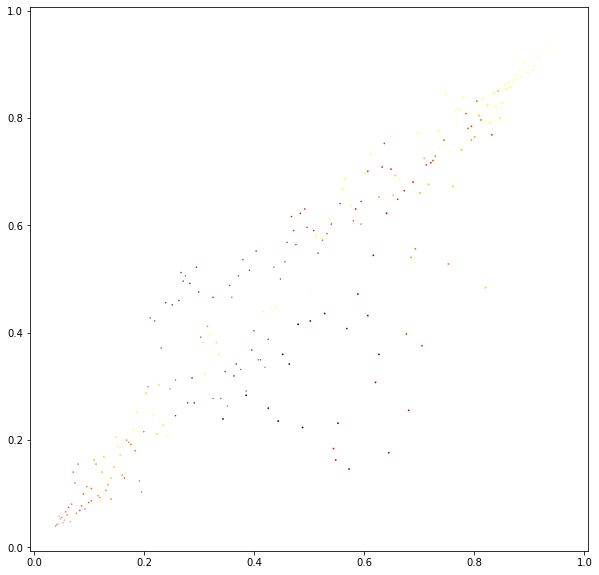

In [204]:
mat = center.u_matrix

fig = plt.figure(figsize=(10, 10))
ax1 = fig.add_subplot(111)
img = ax1.scatter(mat[:, 0], mat[:, 1], mat[:, 2], mat[:, 3])


In [209]:
print(center.unis)

[GaussianKDE, GaussianKDE, GaussianKDE, GaussianKDE]
